### Project: Amazon pet supplies product reviews sentiment analysis using different models 
### Python version: 3.10.12



##### Import packages

In [1]:
import pandas as pd  
import dask.dataframe as dd
import matplotlib as plt
import seaborn as sns
import json
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))


In [2]:

# Read the JSON file line by line
with open('Pet_Supplies.json', 'r') as file:
    data = [json.loads(line) for line in file if line.strip()]


In [3]:
# Convert the list of dictionaries to a DataFrame
df_raw = pd.DataFrame(data)


In [4]:
df = df_raw.copy()

In [5]:
df.head(3)

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,3.0,5,True,"09 27, 2007",A13K4OZKAAHOXS,0972585419,100indecisions,"Either my bird can't talk, or it really doesnt...",Still waiting for it to work...,1190851200,NaN,NaN
1,4.0,6,True,"08 25, 2007",A1DWYEX4P7GB7Z,0972585419,J. Weaver,The CD is a good idea for teaching a bird to s...,Feathered Phonics volume 1,1188000000,NaN,NaN
2,4.0,5,True,"02 20, 2007",A3NVN97YJSKEPC,0972585419,Theresa Ehrhardt,good cd to teach birds to talk and learn new w...,bird cd,1171929600,NaN,NaN


In [6]:
reviews = df[["overall", "reviewText"]]
print(reviews)

         overall                                         reviewText
0            3.0  Either my bird can't talk, or it really doesnt...
1            4.0  The CD is a good idea for teaching a bird to s...
2            4.0  good cd to teach birds to talk and learn new w...
3            1.0  I was not happy with product would like to ret...
4            1.0  This cd is scratched and it constantly skips. ...
...          ...                                                ...
6542478      5.0        Great leash...should last a very long time.
6542479      5.0  The leash arrived on time and was exactly what...
6542480      4.0  Pretty good quality lead. Slightly stretchy, b...
6542481      5.0                                     Great leash...
6542482      4.0  It's a bit stretchy for leather, but made nicely.

[6542483 rows x 2 columns]


In [7]:
reviews.shape

(6542483, 2)

In [8]:
reviews.isnull().sum()

overall          0
reviewText    3796
dtype: int64

In [9]:
review = reviews.dropna()
print(review.shape)

(6538687, 2)


In [10]:
review = review.copy()
review['overall'] = review['overall'].astype(int)

In [11]:
review = review.copy()
review['reviewText'] = review['reviewText'].str.lower()


In [12]:
review.dtypes

overall        int64
reviewText    object
dtype: object

###  classify rating stars < 3 as negative review ("0")

In [15]:
review.loc[review["overall"] < 3.0, 'overall'] = 0

###  classify rating score > 3 as posotive review ("1")

In [16]:
review.loc[review["overall"] > 3.0, 'overall'] = 1

###  classify rating score = 3 as neutral review ("2")

In [17]:
review.loc[review["overall"] == 3.0, 'overall'] = 2

### Check class if balance

In [18]:
review[["overall"]].value_counts()

overall
1          5007910
0          1014556
2           516221
Name: count, dtype: int64

<Axes: xlabel='overall', ylabel='count'>

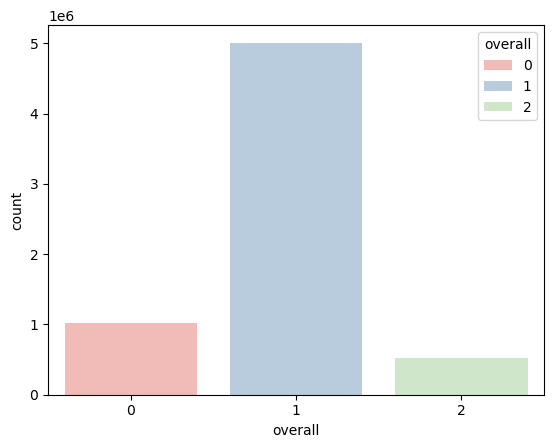

In [19]:
sns.countplot(data=review, x='overall',hue="overall", palette="Pastel1")

### Text preprocessing 

In [24]:
review[["reviewText"]].head(1)

,reviewText
0,"either my bird can't talk, or it really doesnt..."


In [ ]:
def text_prepocessing(text):
    pass    

In [20]:
str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    # Remove URLs
    text = re.sub(r'http\S+', '', text)

NameError: name 'string' is not defined